# 1. Data loading and preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, lasso_path
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
# Kill warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the Parquet file into a DataFrame
# list of files in '../../../Data/All_Data/All_Data_with_NLP_Features'
import os
file_list = [f for f in os.listdir(r'../../../Data/All_Data/All_Data_with_NLP_Features') if f.endswith('.parquet')]
# read in all parquet files
df = pd.concat([pd.read_parquet(r'../../../Data/All_Data/All_Data_with_NLP_Features/' + f) for f in file_list])

# 2. Model

In [3]:
def train_and_evaluate_model(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, test_size=None, random_state=None,
                             penalty='elasticnet', class_weight=None, max_iter=5000, solver="saga",multi_class="ovr", change =False,hyperparameter_settings=None,lassopath=False):
    """
    Trains and evaluates a logistic regression model.

    Parameters:
    - df: DataFrame containing the dataset.
    - numeric_feature_columns: list of numeric columns to be used as features.
    - cat_feature_columns: list of categorical columns to be used as features.
    - target_column: column to be used as target.
    - custom_mapping: dictionary to encode the target variable.
    - test_size: proportion of the dataset to include in the test split.
    - random_state: controls the shuffling applied to the data before applying the split.
    - penalty: regularization type ('elasticnet', 'l1' or 'l2').
    - class_weight: weights associated with classes. If not given, all classes are supposed to have weight one.
    - max_iter: maximum number of iterations taken for the solvers to converge.
    - solver: optimizer choice
    - multi_class: multinomial class ('ovr' or 'multinomial')
    - change: whether predict changes (default is predict true label)
    - hyperparameter_settings: parameters after grid search
    - lassopath: compute lassopath

    Returns:
    A dictionary with accuracy, F1 score, and majority class baseline.
    """
    
    # Selecting features and target, and encoding target
    
    if test_size:
        # Splitting data
        numeric_X = df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        cat_X = df[cat_feature_columns]
        X = pd.concat([numeric_X, cat_X], axis=1)
        
        if change:
            Y = df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        else:
            Y = df[target_column].map(custom_mapping)
            
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    else:
        train_df = df[df['train_test_80_20'] == 'train']
        test_df = df[df['train_test_80_20'] == 'test']

        train_numeric_X = train_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        train_cat_X = train_df[cat_feature_columns]
    
        test_numeric_X = test_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        test_cat_X = test_df[cat_feature_columns]

        X_train = pd.concat([train_numeric_X, train_cat_X], axis=1)
        X_test = pd.concat([test_numeric_X, test_cat_X], axis=1)

        if change:
            y_train = train_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
            y_test = test_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        else:
            y_train =  train_df[target_column].map(custom_mapping)
            y_test = test_df[target_column].map(custom_mapping)
    


    # Preprocessing
    numeric_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature_columns),
            ('cat', cat_transformer, cat_feature_columns)
        ])

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # Model training
    if not hyperparameter_settings:
        model = LogisticRegression(penalty=penalty, max_iter=max_iter, class_weight=class_weight, solver=solver, multi_class=multi_class)
    else:
        model = LogisticRegression(**hyperparameter_settings,max_iter=max_iter)
    model.fit(X_train_scaled, y_train)
    
    # Model prediction and evaluation
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    majority_class_share_baseline = y_test.value_counts(normalize=True).max()
    
    print({'accuracy': accuracy, 'f1_score': f1, 'majority_baseline': majority_class_share_baseline})
    
    ### Calculate the share of predictions that are 1 or fewer ratings away from the actual ratings
    differences = np.abs(y_pred - y_test)
    close_predictions_share = np.mean(differences <= 1)
    exact_predictions_share = np.mean(differences == 0 )

    print(f"Share of predictions exactly as the actual: {exact_predictions_share:.2%}")
    print(f"Share of predictions 1 or fewer ratings away from actual: {close_predictions_share:.2%}")


    ### confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    display_labels = []
    for v in np.sort(np.unique(y_test)):
        for key, value in custom_mapping.items():
            if value == v:
                display_labels.append(key)

    # detailed evaluation with classification report
    report = classification_report(y_test, y_pred, target_names=display_labels)
    print("Classification Report:\n", report)      

    # Confusion Matrix Display
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=display_labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm_display.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Computing the LASSO path
    if lassopath and not cat_feature_columns:
        print("Computing LASSO path...")
        alphas, coefs, _ = lasso_path(X_train_scaled, y_train, eps=1e-3,tol=0.001)
        coefs_lasso = coefs

        all_feature_names = np.array(numeric_feature_columns)
        
        dropping_order_list = []
        for i in range(len(coefs_lasso.T)-1,-1,-1):
            coef_lasso = coefs_lasso.T[i]
            zero_indices = np.where(coef_lasso == 0)[0]
            for ind in zero_indices:
                if ind not in dropping_order_list:
                    dropping_order_list.append(ind)

        print(" ")
        print("names of top 15 important variables:")
        print(all_feature_names[dropping_order_list[0:15]])

In [4]:
def train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings, change=None):

    train_df = df[df['train_test_80_20'] == 'train']
    test_df = df[df['train_test_80_20'] == 'test']

    train_numeric_X = train_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
    train_cat_X = train_df[cat_feature_columns]

    test_numeric_X = test_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
    test_cat_X = test_df[cat_feature_columns]

    X_train = pd.concat([train_numeric_X, train_cat_X], axis=1)
    X_test = pd.concat([test_numeric_X, test_cat_X], axis=1)

    if change:
        y_train = train_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        y_test = test_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
    else:
        y_train =  train_df[target_column].map(custom_mapping)
        y_test = test_df[target_column].map(custom_mapping)

    # Preprocessing
    numeric_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature_columns),
            ('cat', cat_transformer, cat_feature_columns)
        ])

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)
    
    # Create a preprocessing and modeling pipeline
    model = LogisticRegression(max_iter=5000)
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(model, hyperparameter_settings, scoring='accuracy', cv=5, n_jobs=-1)
    
    # Fit the grid search to the data
    grid_search.fit(X_train_scaled, y_train)
    
    # Print the best parameters and the accuracy of the grid search
    print("Tuned Hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    
    # Evaluate the best grid search model on the test data
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Save the best model to a file
    joblib.dump(best_model, 'Best_Logistic_Regression_Model.joblib')
    
    return best_model, grid_search.best_params_

In [5]:
hyperparameter_settings = [
    # Non-penalized
    {'solver': ['lbfgs'], 
     'penalty': [None], 
     'C': [1],  # C is irrelevant here but required as a placeholder
     'class_weight': [None, 'balanced'], 
     'multi_class': ['ovr']},
    # ElasticNet penalty
    {'solver': ['saga'], 
     'penalty': ['elasticnet'], 
     'C': [0.001, 0.01, 0.1, 1, 10], 
     'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0], 
     'class_weight': [None, 'balanced'], 
     'multi_class': ['ovr']}
]

In [10]:
# Load the JSON file
with open('feature_columns.json', 'r') as file:
    column_data = json.load(file)

## Task1: Credit Rating prediction 

### model 1
First, we only use the Altman_Z as covariate

In [6]:
numeric_feature_columns = ["Altman_Z"]
cat_feature_columns = ['Sector']
target_column = "Rating"
custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}

In [7]:
best_model_1, best_params_1 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

Tuned Hyperparameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.5, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.3871863838366216
Test Accuracy: 0.42945874001774625


{'accuracy': 0.4303460514640639, 'f1_score': 0.40073053877397585, 'majority_baseline': 0.31588287488908606}
Share of predictions exactly as the actual: 43.03%
Share of predictions 1 or fewer ratings away from actual: 83.94%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.00      0.00      0.00        19
          AA       0.00      0.00      0.00        43
           A       0.46      0.32      0.38       219
         BBB       0.42      0.68      0.52       356
          BB       0.41      0.41      0.41       313
           B       0.52      0.31      0.39       144
         CCC       0.00      0.00      0.00        27
          CC       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         3
           D       0.00      0.00      0.00         2

    accuracy                           0.43      1127
   macro avg       0.18      0.17      0.17      1127
weighted avg       0.40      0.43      0.40     

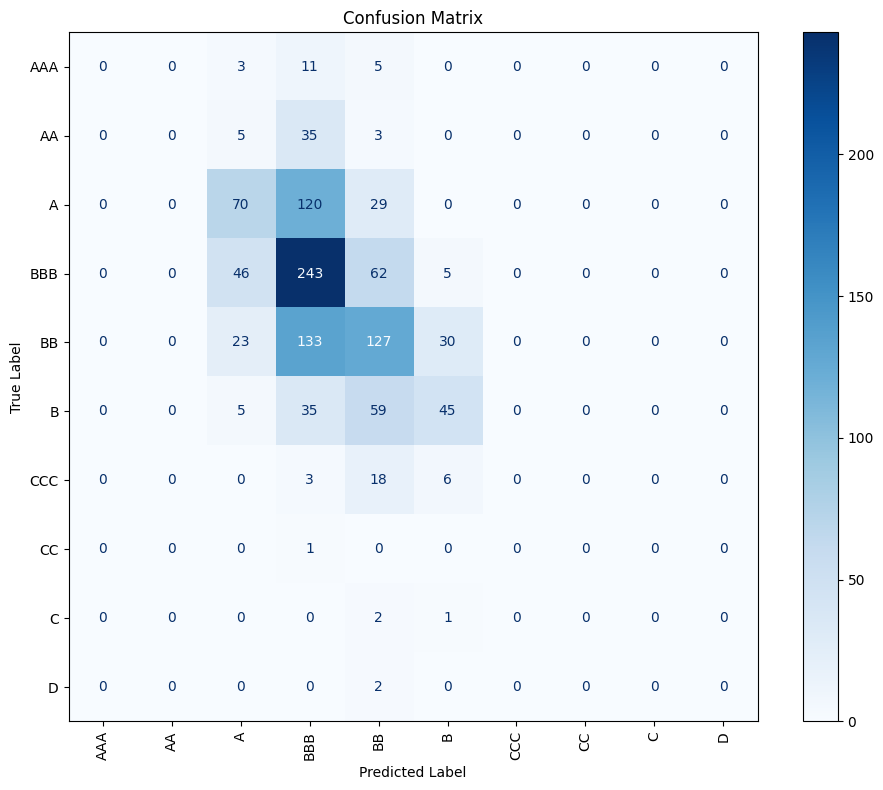

In [8]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_1)

### model 2
we only use tabular financial features

In [13]:
# Extract feature and target column names from the JSON data
cat_feature_columns = []
nlp_feature_columns = []
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}


In [14]:
best_model_2, best_params_2 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

Tuned Hyperparameters: {'C': 0.01, 'class_weight': None, 'l1_ratio': 1.0, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.453440630406653
Test Accuracy: 0.5093167701863354


{'accuracy': 0.5093167701863354, 'f1_score': 0.454598891847006, 'majority_baseline': 0.31588287488908606}
Share of predictions exactly as the actual: 50.93%
Share of predictions 1 or fewer ratings away from actual: 88.73%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.67      0.32      0.43        19
          AA       0.00      0.00      0.00        43
           A       0.52      0.32      0.40       219
         BBB       0.53      0.78      0.63       356
          BB       0.48      0.67      0.56       313
           B       0.59      0.07      0.12       144
         CCC       0.00      0.00      0.00        27
          CC       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         3
           D       0.00      0.00      0.00         2

    accuracy                           0.51      1127
   macro avg       0.28      0.22      0.21      1127
weighted avg       0.49      0.51      0.45      1

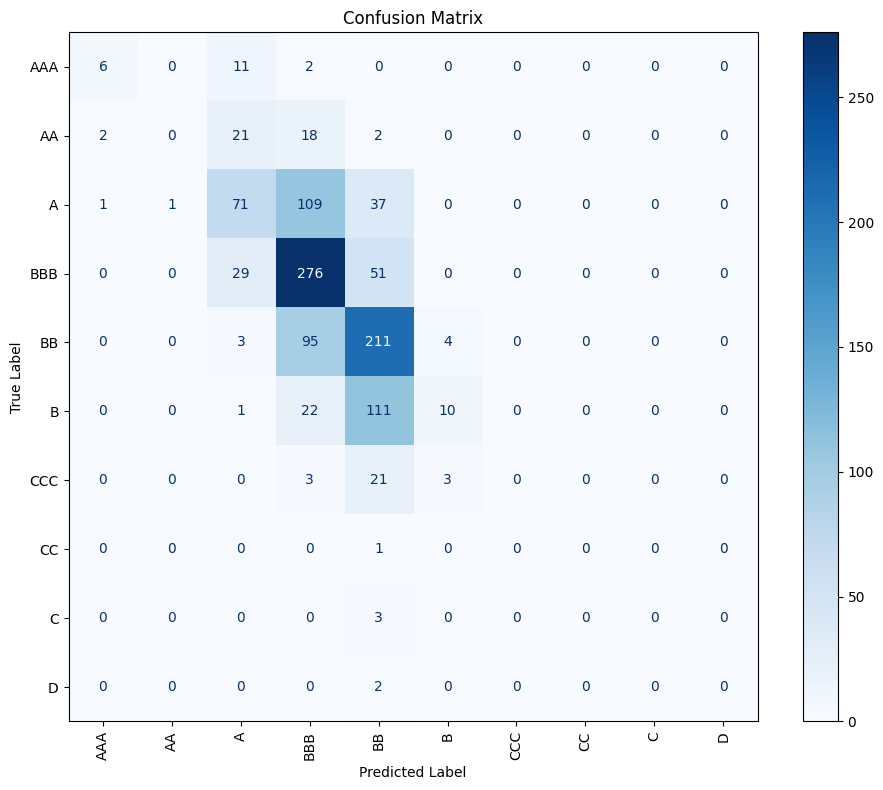

In [15]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_2)

### model 3
We add the categorical features (cat+fin_tabular)

In [14]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = []
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}

In [15]:
best_model_3, best_params_3 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Tuned Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0.25, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.6843522678259016
Test Accuracy: 0.7879325643300799


{'accuracy': 0.7879325643300799, 'f1_score': 0.7897329983236667, 'majority_baseline': 0.31588287488908606}
Share of predictions exactly as the actual: 78.79%
Share of predictions 1 or fewer ratings away from actual: 97.16%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.74      0.89      0.81        19
          AA       0.44      0.51      0.47        43
           A       0.72      0.68      0.70       219
         BBB       0.82      0.82      0.82       356
          BB       0.90      0.82      0.86       313
           B       0.74      0.87      0.80       144
         CCC       0.74      0.74      0.74        27
          CC       0.25      1.00      0.40         1
           C       1.00      0.67      0.80         3
           D       1.00      1.00      1.00         2

    accuracy                           0.79      1127
   macro avg       0.74      0.80      0.74      1127
weighted avg       0.80      0.79      0.79      

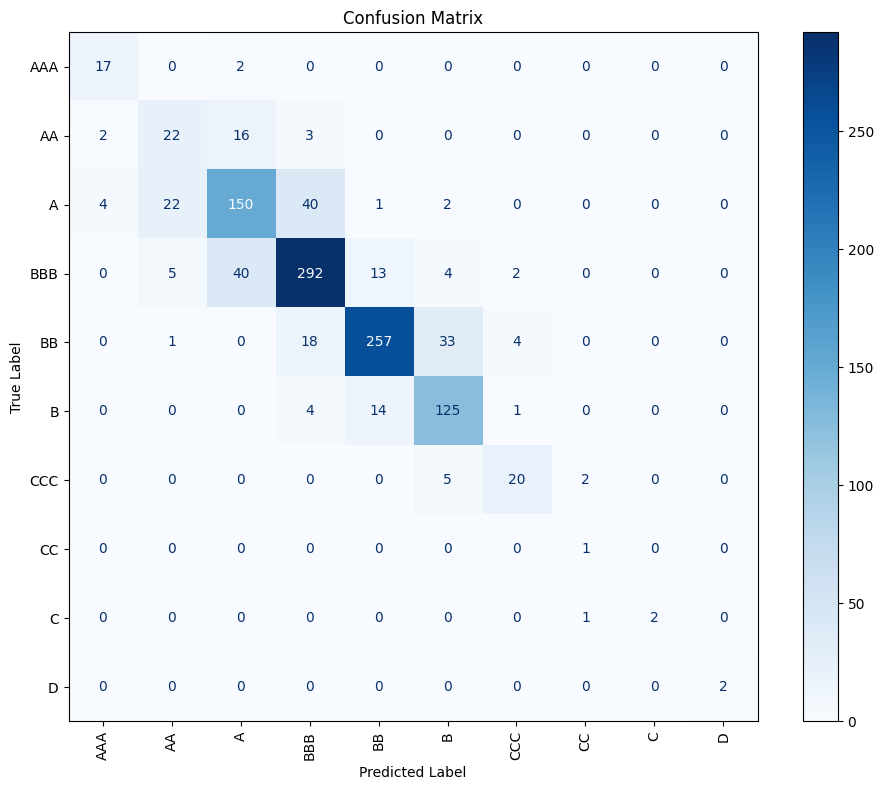

Computing LASSO path...


In [16]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_3)

### model 4
We add the nlp features (nlp+cat+fin_tabular)

In [16]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = column_data['nlp_feature_columns']
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}

In [17]:
best_model_4, best_params_4 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

Tuned Hyperparameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 1.0, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.7151708562926776
Test Accuracy: 0.7790594498669032


{'accuracy': 0.7790594498669032, 'f1_score': 0.7726271246281617, 'majority_baseline': 0.31588287488908606}
Share of predictions exactly as the actual: 77.91%
Share of predictions 1 or fewer ratings away from actual: 96.54%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.86      0.63      0.73        19
          AA       0.61      0.33      0.42        43
           A       0.72      0.71      0.71       219
         BBB       0.76      0.87      0.81       356
          BB       0.86      0.83      0.84       313
           B       0.78      0.81      0.79       144
         CCC       0.78      0.52      0.62        27
          CC       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         3
           D       0.00      0.00      0.00         2

    accuracy                           0.78      1127
   macro avg       0.54      0.47      0.49      1127
weighted avg       0.77      0.78      0.77      

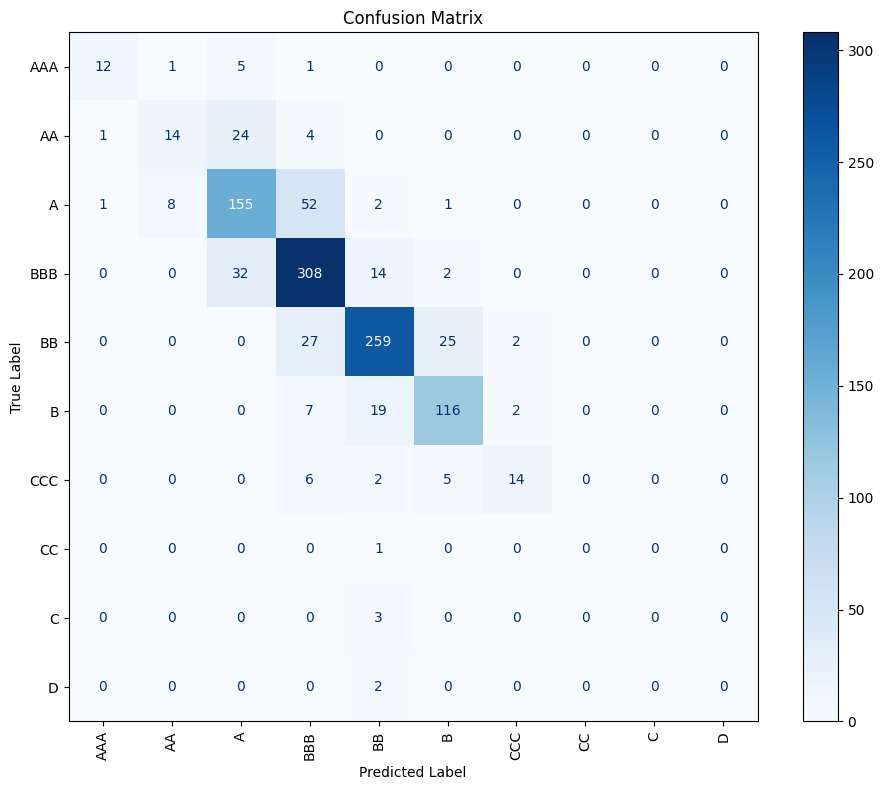

In [18]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_4)

## get top 15 important numerical variables based on Lasso_path

{'accuracy': 0.5749778172138421, 'f1_score': 0.5573568045673498, 'majority_baseline': 0.31588287488908606}
Share of predictions exactly as the actual: 57.50%
Share of predictions 1 or fewer ratings away from actual: 91.57%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.84      0.84      0.84        19
          AA       0.77      0.23      0.36        43
           A       0.62      0.39      0.48       219
         BBB       0.55      0.75      0.64       356
          BB       0.57      0.65      0.61       313
           B       0.57      0.42      0.49       144
         CCC       0.75      0.11      0.19        27
          CC       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         3
           D       0.00      0.00      0.00         2

    accuracy                           0.57      1127
   macro avg       0.47      0.34      0.36      1127
weighted avg       0.59      0.57      0.56      

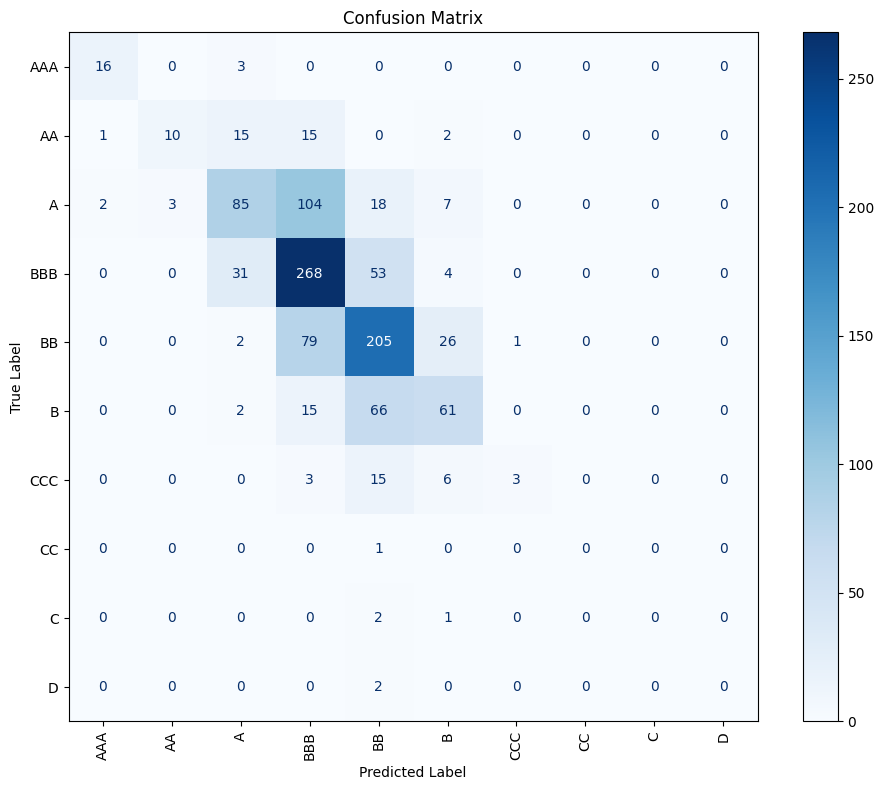

Computing LASSO path...
 
names of top 15 important variables:
['cashAndShortTermInvestments' 'totalNonCurrentAssets'
 'totalLiabilitiesAndStockholdersEquity' 'totalLiabilitiesAndTotalEquity'
 'cashAtBeginningOfPeriod' 'operatingCashFlow' 'capitalExpenditure'
 'revenue' 'epsdiluted' 'EBIT' 'common_plus_preferred_stock'
 'workingCapital' 'TONE1' 'totalInvestments' 'netDebt']


In [19]:
nlp_feature_columns = column_data['nlp_feature_columns']
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

train_and_evaluate_model(df,numeric_feature_columns,[],target_column,custom_mapping,hyperparameter_settings=best_params_4,lassopath=True)

## Task2: Credit Rating Changing Prediction 

# model 1
We add all variables

In [20]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = column_data['nlp_feature_columns']
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = 'Change Since Last Fixed Quarter Date'

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'downgrade': 0, 'no change': 1, 'upgrade': 2}

In [21]:
best_model_5, best_params_5 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings,change=True)

Tuned Hyperparameters: {'C': 0.001, 'class_weight': None, 'l1_ratio': 0.0, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.9443102019453047
Test Accuracy: 0.9556344276841171


In [ ]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_5,change=True)